In [1]:
%load_ext autoreload
%autoreload 2

##### Подбор гиперпараметров модели

Модель `SingleBioModel` содержит следующие гиперпараметры:
- **sample_size** - параметр секвенирования: размер сэмпла текста (мин, макс)
  - мин=макс на основании ранее проведенных экспериментов
  - значения меньше 10 сильно понижают производительность
- **sample_count** - параметр секвенирования: кол-во сэмплов текста
  - значения больше 0.2  сильно понижают производительность
- **filter_eps** - параметр фильтрации
  - константный на основании ранее проведенных экспериментов
- **eps** - гиперпараметр DBSCAN
- **min_samples** - гиперпараметр DBSCAN

Для подбора гиперпараметров была проведена ручная разметка датасета на основе 3-х пар документов. Используемый датасет содержит координаты схожих фрагментов текста в паре документов (номер документа, номер страницы и номер строки на странице для двух документов), а также начальные и конечные слова (для контроля - в расчётах не используются).

Ручная разметка очень трудоемка и количество доступных образцов ограничено, однако предполагается, что размеченные фрагменты достаточно характеры для генеральной совокупности. Были заявлены требования по детектированию фрагментов длиной от нескольких строк (абзац и более). Образцы покрывают 3 разные степени схожести пар документов по кол-ву фрагментов - слабая, средняя и сильная. Априорных знаний о распределении документов разных степеней в генеральной совокупности нет, поэтому предполагается, что их доли одинаковы. 

Было рассчитано несколько метрик для каждой пары документов и их средние значения:
- *ARI* (adjusted RI)
- *AMI* (adjusted MI)
- *homogenity*, *completeness*, *V-measure*

Расчет метрик производится следующим образом:
  - после кластеризации признаки - пары позиций (ref_pos, sample_pos) + метки кластеров
  - для каждой пары вычисляются истинные метки кластеров на основе `ground truth`
  - строятся метрики качества кластеризации

Эксперименты показали, что метрики *ARI*, *AMI*, *V-measure* как правило коррелируют друг с другом в области локальных максимумов. Параметры выбирались по максимуму среднего значения *ARI*.

Операции секвенирования и выравнивания достаточно ресурсоемки, поэтому для оптимизации они были проведены один раз для каждого сочетания параметров **sample_size** и **sample_count** и модель была сохранена на диск, чтобы перебор остальных параметров проходил быстрее.

In [2]:
import os
import numpy as np
import pandas as pd

from page_reader import PageReader
from bio_engine import sequencing, alignment
from bio_engine import calculate_similar_areas
from bio_engine import SingleBioModel
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, jaccard_similarity_score, adjusted_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure

import pickle

Подготовка данных. Предполагается, что в каталогах txt_sample и txt_ref лежат результаты OCR соответствующих файлов из CANDIDATS

In [3]:
PATH_MARKS = '../dataset'
PATH_MARK_FILES = os.path.join(PATH_MARKS, 'files.csv')
PATH_MARK_AREAS = os.path.join(PATH_MARKS, 'areas.csv')

In [4]:
file_df = pd.read_csv(PATH_MARK_FILES)
area_df = pd.read_csv(PATH_MARK_AREAS)

In [5]:
PATH_PDF = '../test_data'

In [6]:
CANDIDATS = [
    { 'path': '1',
      'sample_doc': '1.pdf',
      'sample_skip_pages': [0,1] + list(range(139,148)),
      'sample_page_num_on_top': True,
      'sample_word_hyphen': False,
      'sample_predef_real_page_nums': None,
      'ref_doc': '2.pdf',
      'ref_skip_pages': [0,1] + list(range(124,136)),
      'ref_page_num_on_top': True,
      'ref_word_hyphen': False,
      'ref_predef_real_page_nums': None
    },
    {
      'path': '2',
      'sample_doc': '3.pdf', 
      'sample_page_num_on_top': False,
      'sample_word_hyphen': False,  
      'sample_skip_pages': [0,1] + list(range(179,215)),
      'sample_predef_real_page_nums': None,
      'ref_doc': '4.pdf',
      'ref_skip_pages': [0,1] + list(range(215,242)),
      'ref_page_num_on_top': False,
      'ref_word_hyphen': False,
      'ref_predef_real_page_nums': None
    },
    {
      'path': '3',
      'sample_doc': '5.pdf', 
      'sample_page_num_on_top': True,
      'sample_skip_pages': [0,1] + list(range(174,217)),
      'sample_word_hyphen': False,
      'sample_predef_real_page_nums': list(range(1, 58)) + list(range(63, 94)) + list(range(97, 208)) + \
        [208, 208, 209, 210, 211, 212, 213, 214, 215, 215, 216, 216, 217, 218, 218, 219, 220, 221],  # duplicates 208, 215, 216, 218
      'ref_doc': '6.pdf',
      'ref_skip_pages': [0,1] + list(range(160,201)),
      'ref_page_num_on_top': False,
      'ref_word_hyphen': True,
      'ref_predef_real_page_nums': list(range(1, 45)) + list(range(51, 127)) + list(range(128, 209))
    }
]

In [7]:
PATH_MODEL_DUMP = './models_cv'
if not os.path.exists(PATH_MODEL_DUMP):
    os.mkdir(PATH_MODEL_DUMP)

Подбор гиперпараметров (эффективный - однократное выравнивание по сэмплам)

In [8]:
# sample_sizes = [(10, 10), (12, 12), (14, 14)]
# sample_counts = [0.1, 0.15, 0.2]
# filter_epss = [50, 100, 150]
sample_sizes = [(10, 10), (11, 11)]
sample_counts = [0.1, 0.15, 0.2]
filter_epss = [100]

params_fit = [
    (sample_size, sample_count, filter_eps) 
    for sample_size in sample_sizes 
    for sample_count in sample_counts
    for filter_eps in filter_epss
]

In [9]:
# %%time
RS = 42
DELIM = '-------------'

models = {}
for candidat in CANDIDATS:
    path = candidat['path']
    print(DELIM, path, DELIM)

    txt_sample_path = os.path.join(PATH_PDF, path, 'txt-sample')
    txt_ref_path = os.path.join(PATH_PDF, path, 'txt-ref')
    
    sample_skip_pages = candidat['sample_skip_pages']
    ref_skip_pages = candidat['ref_skip_pages']

#     sample_page_num_on_top = candidat['sample_page_num_on_top'] 
#     ref_page_num_on_top = candidat['ref_page_num_on_top']

#     sample_word_hyphen = candidat['sample_word_hyphen']
#     ref_word_hyphen = candidat['ref_word_hyphen']

    sample_predef_real_page_nums = candidat['sample_predef_real_page_nums']
    ref_predef_real_page_nums = candidat['ref_predef_real_page_nums']
    
    sample_reader = PageReader(txt_sample_path, sample_skip_pages, page_num_on_top=None, word_hyphen=None, 
                             predef_real_page_nums=sample_predef_real_page_nums)
    sample_reader.read_pages(verbose=False)

    ref_reader = PageReader(txt_ref_path, ref_skip_pages, page_num_on_top=None, word_hyphen=None,
                            predef_real_page_nums=ref_predef_real_page_nums)
    ref_reader.read_pages(verbose=False)

    for sample_size, sample_count, filter_eps in params_fit:
        fn_model = os.path.join(PATH_MODEL_DUMP, f'{path}_{sample_size}_{sample_count}_{filter_eps}.pkl')
        if os.path.exists(fn_model):
            print(f'Loading model from dump {fn_model}')
            with open(fn_model, 'rb') as f:
                model = pickle.load(f)
        else:
            print(f'Fitting model with sample_size, sample_count, filter_eps = ' +
                  f'{sample_size}, {sample_count}, {filter_eps}')
            np.random.seed(RS)
            model = SingleBioModel(sample_reader, ref_reader, sample_size, sample_count)
            model.fit_transform(eps=filter_eps, verbose=True)
            with open(fn_model, 'wb') as f:
                pickle.dump(model, f)
        models[(path, sample_size, sample_count, filter_eps)] = model

------------- 1 -------------


WARN no lines found on page 135, skipping
Loading model from dump ./models_cv/1_(10, 10)_0.1_100.pkl
Loading model from dump ./models_cv/1_(10, 10)_0.15_100.pkl
Loading model from dump ./models_cv/1_(10, 10)_0.2_100.pkl
Loading model from dump ./models_cv/1_(11, 11)_0.1_100.pkl
Loading model from dump ./models_cv/1_(11, 11)_0.15_100.pkl
Loading model from dump ./models_cv/1_(11, 11)_0.2_100.pkl
------------- 2 -------------


Loading model from dump ./models_cv/2_(10, 10)_0.1_100.pkl
Loading model from dump ./models_cv/2_(10, 10)_0.15_100.pkl
Loading model from dump ./models_cv/2_(10, 10)_0.2_100.pkl
Loading model from dump ./models_cv/2_(11, 11)_0.1_100.pkl
Loading model from dump ./models_cv/2_(11, 11)_0.15_100.pkl
Loading model from dump ./models_cv/2_(11, 11)_0.2_100.pkl
------------- 3 -------------

WARN no lines found on page 212, skipping

Loading model from dump ./models_cv/3_(10, 10)_0.1_100.pkl
Loading model from dump ./models_cv/3_(10, 10)_0.

In [10]:
def fill_labels(df, positions):
    '''Fill dataframe labels based on positions
    Input:
      df:pd.DataFrame - dataframe with links in ['sample_pos', 'ref_pos'] columns
      positions:list(tuple(int*4)) - areas with positions: (ref_begin, ref_end, sample_begin, sample_end)
    '''
    df = df.copy()
    df['label'] = np.nan
    for idx, (a, b, c, d) in enumerate(positions):
        df.loc[df['ref_pos'].between(a, b) & df['sample_pos'].between(c, d), 'label'] = idx
    df['label'] = df['label'].fillna(-1).astype(int)
    return df

In [11]:
# epss = np.linspace(350, 700, 8)
# min_sampless = np.linspace(20, 120, 11)
# epss = np.linspace(450, 650, 9)
# min_sampless = np.linspace(40, 100, 7)
# epss = [500]
# min_sampless = [75]
epss = np.linspace(400, 800, 5)
min_sampless = np.linspace(20, 80, 7)
taus = [0.0]

params_combinations = [
    (sample_size, sample_count, filter_eps, eps, min_samples, tau)  
    for sample_size in sample_sizes
    for sample_count in sample_counts
    for filter_eps in filter_epss
    for eps in epss
    for min_samples in min_sampless
    for tau in taus
]

In [12]:
%%time
metrics = []
for idx, params in enumerate(params_combinations):
    sample_size, sample_count, filter_eps, eps, min_samples, tau = params
    params_dict = {
        'sample_size': sample_size,
        'sample_count': sample_count,
        'filter_eps': filter_eps,
        'eps': eps,
        'min_samples': min_samples,
        'use_custom_metric': tau > 0,
        'tau': tau
    }
    print(f'*** Step {idx+1} of {len(params_combinations)} - params: {params_dict}')

    metric = {}
    for idx, candidat in enumerate(CANDIDATS):
        path = candidat['path']
        print(DELIM, path, DELIM)
        
        sample_doc = candidat['sample_doc']
        ref_doc = candidat['ref_doc']

        if (path, sample_size, sample_count, filter_eps) not in models:
            print(f'Model for params {(path, sample_size, sample_count, filter_eps)} not found, skipping')
            continue

        model = models[(path, sample_size, sample_count, filter_eps)]
        model.predict(use_custom_metric=(tau > 0), tau=tau,
                      eps=eps, min_samples=min_samples, 
                      show=False, verbose=False)
        df_areas_pred = model.areas_df
        
        area_pred_page_coords = df_areas_pred[['ref_begin_page_coords',
                                               'ref_end_page_coords', 
                                               'sample_begin_page_coords', 
                                               'sample_end_page_coords']].apply(tuple, axis=1).values.tolist()
        area_pred_positions = df_areas_pred[['ref_begin', 'ref_end', 
                                             'sample_begin', 'sample_end']].apply(tuple, axis=1).values.tolist()
        area_pred_real_coords = [(
            model.ref_reader.convert_page_to_real_coords(a),
            model.ref_reader.convert_page_to_real_coords(b),
            model.sample_reader.convert_page_to_real_coords(c),
            model.sample_reader.convert_page_to_real_coords(d)
            ) for a, b, c, d in area_pred_page_coords
        ]

        sample_mark_ids = file_df[file_df['filename'] == sample_doc]['file_id']
        if sample_mark_ids.shape[0] == 0:
            print(f'File `{sample_doc}` row not found in CSV, ignoring')
            continue
        sample_mark_id = sample_mark_ids.iloc[0]
        ref_mark_ids = file_df[file_df['filename'] == ref_doc]['file_id']
        if ref_mark_ids.shape[0] == 0:
            print(f'File `{ref_doc}` row not found in CSV, ignoring')
            continue
        ref_mark_id = ref_mark_ids.iloc[0]
        print('sample and ref file ids:', sample_mark_id, ref_mark_id)

        df_areas = area_df.query(f'file_id1 == {sample_mark_id} & file_id2 == {ref_mark_id}')
        columns_to_drop = ['file_id1', 'file_id2']
        area_real_coords = df_areas.drop(columns_to_drop, axis=1).dropna().values.astype('int32')
        area_real_coords = [((e, f), (g, h), (a, b), (c, d)) 
                            for a, b, c, d, e, f, g, h 
                            in area_real_coords]
        area_positions = [(
            model.ref_reader.convert_real_coords_to_position(a),
            model.ref_reader.convert_real_coords_to_position(b),
            model.sample_reader.convert_real_coords_to_position(c),
            model.sample_reader.convert_real_coords_to_position(d)
            ) for a, b, c, d in area_real_coords
        ]

        cur_metrics = {}
        cur_metrics['params'] = params_dict
        cur_metrics['params_str'] = str(params_dict)

        # sklearn metrics
        df_links_raw = pd.DataFrame.from_records(model.links_raw, columns = ['sample_pos', 'ref_pos'])
        df_areas = fill_labels(df_links_raw, area_positions)
        df_areas_pred = fill_labels(df_links_raw, area_pred_positions)
        
        ars = adjusted_rand_score(df_areas['label'], df_areas_pred['label'])
        jss = jaccard_similarity_score(df_areas['label'], df_areas_pred['label'])
        amis = adjusted_mutual_info_score(df_areas['label'], df_areas_pred['label'], average_method='arithmetic')
        hs, cs, vs = homogeneity_completeness_v_measure(df_areas['label'], df_areas_pred['label'])
        
        print('-------------------')
        print('ARI:', ars)
        print('J:', jss)
        print('AMI:', amis)
        print('H:', hs)
        print('C:', cs)
        print('V:', vs)
        print('-------------------')

        cur_metrics['ars'] = ars
        cur_metrics['jss'] = jss
        cur_metrics['amis'] = amis
        cur_metrics['hs'] = hs
        cur_metrics['cs'] = cs
        cur_metrics['vs'] = vs
        
        metric[idx] = cur_metrics
        
    if metric:
        metrics.append(metric)


# calculate mean and std for metrics
if metrics:
    keys = []
    first_metric = metrics[0][0]
    for k in first_metric:
        if type(first_metric[k]) == float or type(first_metric[k]) == np.float64:
            keys.append(k)

    for metric in metrics:
        metric_mean, metric_std = {}, {}
        for k in keys:
            values = []
            for m in metric.values():
                values.append(m[k])
            metric_mean[k] = np.mean(values)
            metric_std[k] = np.std(values)
        metric_mean['params'] = metric[0]['params']
        metric_std['params'] = metric[0]['params']
        metric['mean'] = metric_mean
        metric['std'] = metric_std

*** Step 1 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 400.0, 'min_samples': 20.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8816793178647528
JS: 0.9504041238145284
AMI: 0.8252967211807226
H: 0.8908359532059216
C: 0.7710085439978808
V: 0.8266021669030205
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8138069959656548
JS: 0.9713237496256364
AMI: 0.6990042881912958
H: 0.7081008835759258
C: 0.6909966298050988
V: 0.69944420518704
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.6837783725506071
JS: 0.9376982640789503
AMI: 0.6344001187356563
H: 0.7158153564464221
C: 0.5746101008885733
V: 0.6374870115081603
-------------------
*** Step 2 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 400.0, 'min_samples': 30

-------------------
ARI: 0.5974123977456449
JS: 0.9724723651610444
AMI: 0.5008725187102095
H: 0.4359777064402076
C: 0.5903120870552676
V: 0.5015404253836075
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.6409654603105825
JS: 0.9450062260122472
AMI: 0.5955618177290277
H: 0.5757402200320092
C: 0.6235570292324147
V: 0.5986953800368833
-------------------
*** Step 11 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 500.0, 'min_samples': 50.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8463655605319049
JS: 0.9540658442392547
AMI: 0.7650267594704742
H: 0.7558185457633312
C: 0.7782665115299388
V: 0.7668782903064391
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.5005137832116794
JS: 0.9730100873968799
AMI: 0.42771056738564134
H: 0.3429105622665758
C: 0.571

-------------------
ARI: 0.6354796304363846
JS: 0.9567266388075637
AMI: 0.5747136847265903
H: 0.4508623614627029
C: 0.8019626825675327
V: 0.5772151356492767
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.4366110385688212
JS: 0.973990239320428
AMI: 0.36573259520097673
H: 0.26225932128000984
C: 0.6075175916155471
V: 0.3663632567858044
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.19157752222343302
JS: 0.9533065086636001
AMI: 0.15463536712863724
H: 0.09057646348281237
C: 0.5803832703528673
V: 0.15669811895456023
-------------------
*** Step 21 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 600.0, 'min_samples': 80.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.3599699315681657
JS: 0.9555088456822561
AMI: 0.3364390178340683
H: 0.21440486066139428
C: 

sample and ref file ids: 5 6
-------------------
ARI: 0.6385899967060666
JS: 0.9237193460926572
AMI: 0.5523963260824746
H: 0.7208594150351634
C: 0.4521141780114993
V: 0.5557000836548378
-------------------
*** Step 30 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 800.0, 'min_samples': 30.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7561605890229941
JS: 0.93418912494057
AMI: 0.6797373002939033
H: 0.8148958599710112
C: 0.5858801754934163
V: 0.6816669008623952
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.898599928041401
JS: 0.9709391761278554
AMI: 0.8224682289856213
H: 0.8687543553467247
C: 0.7812101402409523
V: 0.8226597767288609
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.6894457594697561
JS: 0.9300926059302367
AMI: 0.6049669135309436
H: 0.

sample and ref file ids: 1 2
-------------------
ARI: 0.887072897381399
JS: 0.9515336306544098
AMI: 0.8206582991860215
H: 0.8606877866528267
C: 0.7862855616729794
V: 0.8218061092990033
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.5525789560601536
JS: 0.9734804305398109
AMI: 0.4651398151214149
H: 0.407085047118052
C: 0.5444763734546146
V: 0.4658620775294695
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.5728836301885326
JS: 0.9480179316877595
AMI: 0.5274516849646588
H: 0.4620406222307012
C: 0.6231401603923175
V: 0.5306324477082536
-------------------
*** Step 40 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 400.0, 'min_samples': 60.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8464298982400251
JS: 0.9531889960862838
AMI: 0.7501803555466732
H: 

sample and ref file ids: 5 6
-------------------
ARI: 0.48615905313418134
JS: 0.9490907488792695
AMI: 0.441555853361751
H: 0.34639856116973183
C: 0.6211489575802167
V: 0.44476390256440274
-------------------
*** Step 49 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 500.0, 'min_samples': 80.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7571064330102192
JS: 0.9553392645854192
AMI: 0.6711409940452664
H: 0.611371162181168
C: 0.749093138755343
V: 0.6732612425148307
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.4962470790754499
JS: 0.9748173945563126
AMI: 0.4188937795737018
H: 0.3296453643064552
C: 0.5768212834025666
V: 0.4195332781134902
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.2450931303626755
JS: 0.9512980647435262
AMI: 0.21982571052846428


sample and ref file ids: 1 2
-------------------
ARI: 0.7056268776211687
JS: 0.9321527714571767
AMI: 0.6310597752024378
H: 0.8101431083820457
C: 0.519461294369622
V: 0.6330273678905182
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8765564423036026
JS: 0.9708135145558451
AMI: 0.7833509464683418
H: 0.8693328631896388
C: 0.7132208480839453
V: 0.7835769712389515
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.715823380684106
JS: 0.9329874764563989
AMI: 0.635588130670374
H: 0.7495993870982719
C: 0.5548336695037174
V: 0.6376762325923985
-------------------
*** Step 59 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 700.0, 'min_samples': 40.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7286260557240403
JS: 0.931071948666606
AMI: 0.6542646117803312
H: 0.

sample and ref file ids: 5 6
-------------------
ARI: 0.7159313266476677
JS: 0.9328597076738372
AMI: 0.6329304980879515
H: 0.718245140605904
C: 0.5686626167209075
V: 0.6347605860305743
-------------------
*** Step 68 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 800.0, 'min_samples': 60.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7355188095828749
JS: 0.9304974060253026
AMI: 0.6604382059249867
H: 0.8028961317624397
C: 0.5631563767275765
V: 0.661989306621484
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8852554067265231
JS: 0.9716748279126298
AMI: 0.7993545159866723
H: 0.85200221844128
C: 0.7531161039380198
V: 0.7995131353904249
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.6951607655199604
JS: 0.937164193900142
AMI: 0.6332372964420017
H: 0.6

sample and ref file ids: 1 2
-------------------
ARI: 0.8178889150792364
JS: 0.9600445069410677
AMI: 0.7335001842998977
H: 0.6786570037420574
C: 0.8016608155040282
V: 0.7350485415955608
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.5071845045316552
JS: 0.9742110039443143
AMI: 0.4295595114985114
H: 0.35523203869509784
C: 0.545182903357481
V: 0.4301715246526451
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.3939230707938846
JS: 0.9496857521367817
AMI: 0.3568341508139025
H: 0.2539963467142488
C: 0.6168614556478403
V: 0.35983040110201536
-------------------
*** Step 78 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.2, 'filter_eps': 100, 'eps': 500.0, 'min_samples': 20.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8506508482990087
JS: 0.9462937896170913
AMI: 0.7919090131269887
H

sample and ref file ids: 5 6
-------------------
ARI: 0.7057936915369416
JS: 0.9289319031625407
AMI: 0.6298996387128911
H: 0.7617028857634455
C: 0.5399210774007192
V: 0.6319174421787549
-------------------
*** Step 87 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.2, 'filter_eps': 100, 'eps': 600.0, 'min_samples': 40.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8088791664170397
JS: 0.9414137962756101
AMI: 0.7355573830395434
H: 0.826924080466269
C: 0.6639368859516517
V: 0.7365212602250181
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8767084786257825
JS: 0.9709752809946562
AMI: 0.7821090626829131
H: 0.8779675483427776
C: 0.7054491412733059
V: 0.7823101235523962
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.7202262071967684
JS: 0.9327315870122413
AMI: 0.6479291601217072
H: 

sample and ref file ids: 1 2
-------------------
ARI: 0.8122628300544731
JS: 0.9402836003311736
AMI: 0.7383739945573153
H: 0.8206414608946598
C: 0.6725961228382966
V: 0.7392798987261678
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8733736037986057
JS: 0.970987712422015
AMI: 0.7794361877506972
H: 0.8668799802958594
C: 0.7083114542654311
V: 0.7796144723043908
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.7316970788140476
JS: 0.9348640449943446
AMI: 0.6603546936763507
H: 0.7366762139538479
C: 0.6010428275866389
V: 0.6619834821828537
-------------------
*** Step 97 of 210 - params: {'sample_size': (10, 10), 'sample_count': 0.2, 'filter_eps': 100, 'eps': 700.0, 'min_samples': 70.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8167024131934802
JS: 0.941067728525182
AMI: 0.7430909745141948
H: 0

sample and ref file ids: 5 6
-------------------
ARI: 0.7275260849879575
JS: 0.935381161731286
AMI: 0.6535754779286848
H: 0.7151804794488258
C: 0.6043538736468022
V: 0.6551130587808979
-------------------
*** Step 106 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 400.0, 'min_samples': 20.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.904249544084406
JS: 0.9369057804234399
AMI: 0.8502864123540311
H: 0.9002491465517789
C: 0.8080831721202024
V: 0.8516799431735741
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8214451248970719
JS: 0.9650032270556345
AMI: 0.7084636978315382
H: 0.760637030261029
C: 0.6640801007489041
V: 0.7090866035014634
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.7102277016374375
JS: 0.9201301711151454
AMI: 0.6624923006491283
H: 0

-------------------
ARI: 0.9009320677706687
JS: 0.93623097593599
AMI: 0.837327955163149
H: 0.8550144757452511
C: 0.823168935949498
V: 0.8387895522216696
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.71478623352819
JS: 0.966841357945011
AMI: 0.6026222385562905
H: 0.5785907093701267
C: 0.6303295350087045
V: 0.6033529746786902
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.6478135572403703
JS: 0.9346247440998108
AMI: 0.5970889821880557
H: 0.5761639602449717
C: 0.6287348740185448
V: 0.6013025569571122
-------------------
*** Step 116 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 500.0, 'min_samples': 50.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8463475597144592
JS: 0.9404244038222854
AMI: 0.7663451077920665
H: 0.7400912478463486
C: 0.7993993243

sample and ref file ids: 5 6
-------------------
ARI: 0.44814064983134727
JS: 0.9365415813666036
AMI: 0.3912649347139746
H: 0.29338260462039034
C: 0.6082516237332142
V: 0.3958377799416173
-------------------
*** Step 125 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 600.0, 'min_samples': 70.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.655115812201094
JS: 0.9437984262595346
AMI: 0.5930475980378314
H: 0.4699089256670535
C: 0.8148026433793908
V: 0.5960606940984791
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.5123688552634748
JS: 0.9694539821866529
AMI: 0.4209722047776437
H: 0.3214506630180864
C: 0.6133317839562229
V: 0.4218220169643644
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.1765810957142685
JS: 0.9395303024450539
AMI: 0.14181629345245256

sample and ref file ids: 1 2
-------------------
ARI: 0.7517802222319491
JS: 0.9129020207984383
AMI: 0.6723518578759599
H: 0.7973298732756802
C: 0.5848619185203076
V: 0.6747658062295863
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8168803310515546
JS: 0.9589647605524719
AMI: 0.7087148464672687
H: 0.8846898023851637
C: 0.5919543134222349
V: 0.7093055651750132
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.6655623951641826
JS: 0.9053748696357526
AMI: 0.5802086963388347
H: 0.7269144670364296
C: 0.48814983024273045
V: 0.584073080707585
-------------------
*** Step 135 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.1, 'filter_eps': 100, 'eps': 800.0, 'min_samples': 30.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7911322166460558
JS: 0.9192283128682806
AMI: 0.715674624052181
H:

sample and ref file ids: 5 6
-------------------
ARI: 0.6644997490416698
JS: 0.9299444653332579
AMI: 0.6260107791050444
H: 0.6310074349039732
C: 0.6277307993688597
V: 0.6293648524131651
-------------------
*** Step 144 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 400.0, 'min_samples': 50.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.9044726729017565
JS: 0.937640889934333
AMI: 0.843571925980249
H: 0.8637693163528244
C: 0.8265523696755455
V: 0.8447511277713917
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.5977374854415566
JS: 0.9682006474437288
AMI: 0.5003706825058252
H: 0.46299354905401136
C: 0.5465432044754502
V: 0.501311075732036
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.5891930673292981
JS: 0.9322204217174154
AMI: 0.5405278176341687
H:

sample and ref file ids: 1 2
-------------------
ARI: 0.8712456551112993
JS: 0.9380084288934627
AMI: 0.7973163193841115
H: 0.7944184678885791
C: 0.8033076361984214
V: 0.798838323989975
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.5860354693944754
JS: 0.9687009930888653
AMI: 0.49285278731905563
H: 0.4383233803173613
C: 0.5650249873729571
V: 0.49367432170982484
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.4869606614256645
JS: 0.9345163426312585
AMI: 0.4396269803174522
H: 0.3451948418555205
C: 0.6212154078666868
V: 0.4437874174831943
-------------------
*** Step 154 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 500.0, 'min_samples': 80.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7385423972338078
JS: 0.9406873795288967
AMI: 0.6640809982702811

sample and ref file ids: 5 6
-------------------
ARI: 0.7107737636978266
JS: 0.9109482153374172
AMI: 0.6297309813731014
H: 0.7637176427733633
C: 0.5400320237532472
V: 0.6326858518809689
-------------------
*** Step 163 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 700.0, 'min_samples': 30.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.747855296290566
JS: 0.9132526381129733
AMI: 0.6731303087303234
H: 0.8165461274827436
C: 0.5755666657445081
V: 0.6751992141848131
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.867712411624013
JS: 0.9650642051311065
AMI: 0.7728079034733111
H: 0.8718911121846329
C: 0.6944939447516127
V: 0.7731471839744732
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.7271472900059063
JS: 0.9143255482758965
AMI: 0.6508822228120578
H:

sample and ref file ids: 1 2
-------------------
ARI: 0.7677513737584684
JS: 0.9143552549903623
AMI: 0.6927530535577695
H: 0.8071531530321874
C: 0.6093290357613426
V: 0.6944271609482543
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8807190146452805
JS: 0.9660931845143906
AMI: 0.7926432945694958
H: 0.8644840935248389
C: 0.7322526408263194
V: 0.7928930885317688
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.7386087033207149
JS: 0.916501682011626
AMI: 0.6587154883889045
H: 0.7364192914611831
C: 0.5995217185644969
V: 0.6609563684138583
-------------------
*** Step 173 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.15, 'filter_eps': 100, 'eps': 800.0, 'min_samples': 60.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7777843712875488
JS: 0.9159479238132575
AMI: 0.7019861059239699
H

sample and ref file ids: 5 6
-------------------
ARI: 0.5586404475379708
JS: 0.9328104057035271
AMI: 0.5105223491785719
H: 0.43551946790476664
C: 0.6278336204865238
V: 0.5142859268705984
-------------------
*** Step 182 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.2, 'filter_eps': 100, 'eps': 400.0, 'min_samples': 80.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.8186102675299495
JS: 0.9552159142998876
AMI: 0.7318410602972226
H: 0.692300496669978
C: 0.7804517421448985
V: 0.7337379831771945
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.5550855717643972
JS: 0.9692385675941292
AMI: 0.4673662691341195
H: 0.40589734297433333
C: 0.5529799861983776
V: 0.4681581267742685
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.3884945799789148
JS: 0.9346618615736854
AMI: 0.3503509064405466


sample and ref file ids: 1 2
-------------------
ARI: 0.7408427052871376
JS: 0.9233169861792243
AMI: 0.664936512802864
H: 0.819149563086815
C: 0.5623134822209952
V: 0.6668565544965716
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8606580717275177
JS: 0.9646131633262467
AMI: 0.7626834857935781
H: 0.88452398586951
C: 0.6708665065955368
V: 0.7630206295781033
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.7154246004275949
JS: 0.9087075794952566
AMI: 0.643723571311992
H: 0.7785696656058928
C: 0.5524086158778596
V: 0.6462743942934721
-------------------
*** Step 192 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.2, 'filter_eps': 100, 'eps': 600.0, 'min_samples': 40.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7625163296114983
JS: 0.9157880856247606
AMI: 0.688010627954637
H: 0.82

sample and ref file ids: 5 6
-------------------
ARI: 0.7410912734406445
JS: 0.916546278573701
AMI: 0.6689699787395382
H: 0.7757323471540459
C: 0.5913266395298268
V: 0.6710920398978544
-------------------
*** Step 201 of 210 - params: {'sample_size': (11, 11), 'sample_count': 0.2, 'filter_eps': 100, 'eps': 700.0, 'min_samples': 60.0, 'use_custom_metric': False, 'tau': 0.0}
------------- 1 -------------
sample and ref file ids: 1 2
-------------------
ARI: 0.7687229173508926
JS: 0.9167927762742303
AMI: 0.6937402967779304
H: 0.8172149918937692
C: 0.6049154305123084
V: 0.6952188784572327
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8671277893192425
JS: 0.9655662851033942
AMI: 0.7736035815536637
H: 0.8635445937584654
C: 0.701045559235942
V: 0.773856465219287
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.720759682401949
JS: 0.9166323321563985
AMI: 0.6664181350926024
H: 0.

sample and ref file ids: 1 2
-------------------
ARI: 0.7739598886630683
JS: 0.9155243543292748
AMI: 0.6977257206049905
H: 0.8057559466814431
C: 0.6173115629056427
V: 0.6990567340136414
-------------------
------------- 2 -------------
sample and ref file ids: 3 4
-------------------
ARI: 0.8667345437600188
JS: 0.9656795272947384
AMI: 0.7737536938507823
H: 0.8551815214843492
C: 0.706858695701059
V: 0.77397814500998
-------------------
------------- 3 -------------
sample and ref file ids: 5 6
-------------------
ARI: 0.7168737078292009
JS: 0.91797268189902
AMI: 0.6611624989964575
H: 0.7149652196322525
C: 0.61844998102904
V: 0.6632146180705013
-------------------
CPU times: user 34min 39s, sys: 23.7 s, total: 35min 2s
Wall time: 24min 31s


In [13]:
def plot_graphics(metrics, title):
    '''Plot metric graphics'''
    
    def plot_graphic(attr, label, style):
        values = list(map(lambda x: x[attr], metrics)) 
        plt.plot(values, style, label=label)
    
    graph_params = [
        ('ars',       'ARI',  '-'),
        ('jss',       'JI',  '-.'),
        ('amis',      'AMI',  '-.'),
        ('hs',        'H',  '-.'),
        ('cs',        'C',  '-.'),
        ('vs',        'V',  '-.')
    ]

#     metrics = [x for x in metrics if x['params']['filter_eps'] == 30]

    ars_metrics = [m['ars'] for m in metrics]
    ars_max = np.max(ars_metrics)
    params_max = metrics[np.argmax(ars_metrics)]['params']
    title = f'{title}, ARI max = {ars_max} for\n {params_max}'
    
    plt.figure(figsize=(16, 6))
    plt.title(title)
    plt.xlabel('(sample_size, sample_count, eps, min_samples)')
    plt.ylabel('Metrics')
    plt.grid()
    xlabels = [(m['params']['sample_size'], 
                m['params']['sample_count'], 
                m['params']['filter_eps'],
                m['params']['eps'], 
                m['params']['min_samples'],
                m['params']['tau'] > 0,
                m['params']['tau']) for m in metrics]
    plt.xticks(range(len(xlabels)), xlabels, rotation=90)

    for attr, label, style in graph_params:
        plot_graphic(attr, label, style)

    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

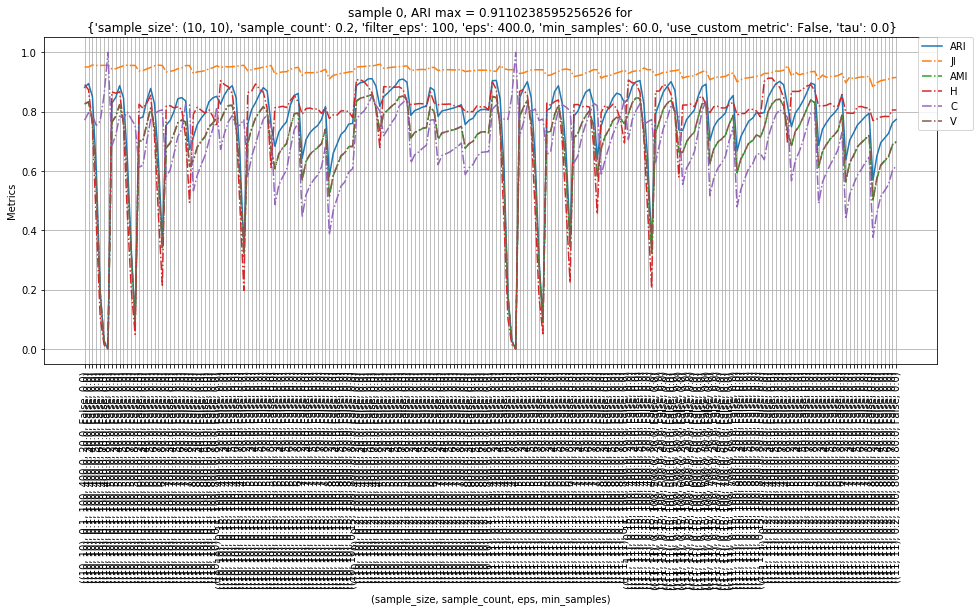

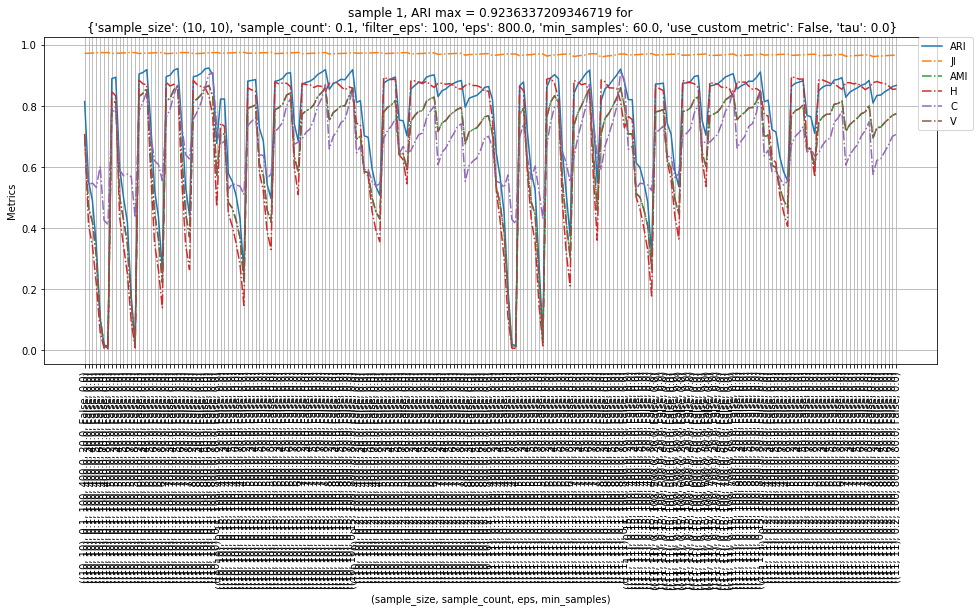

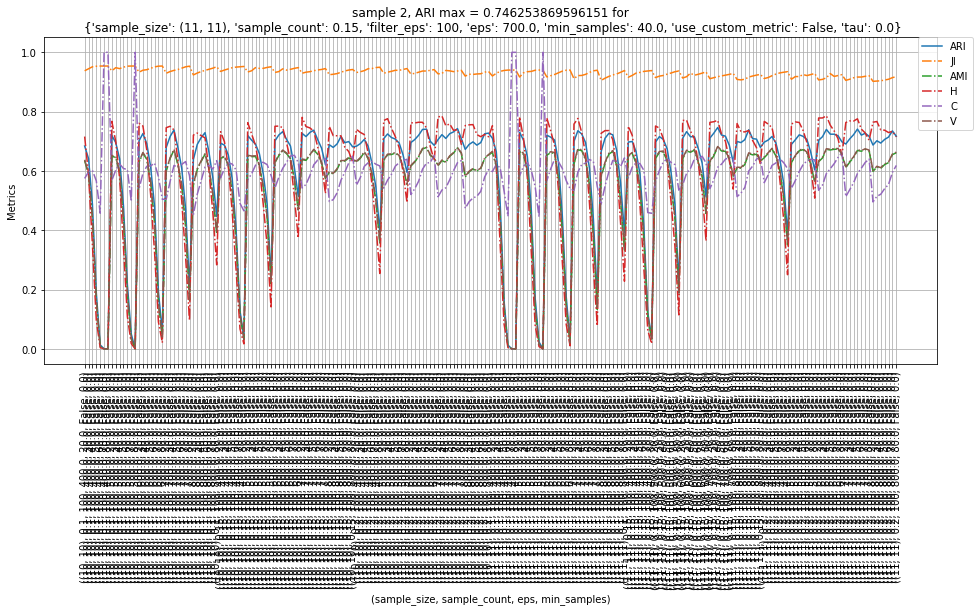

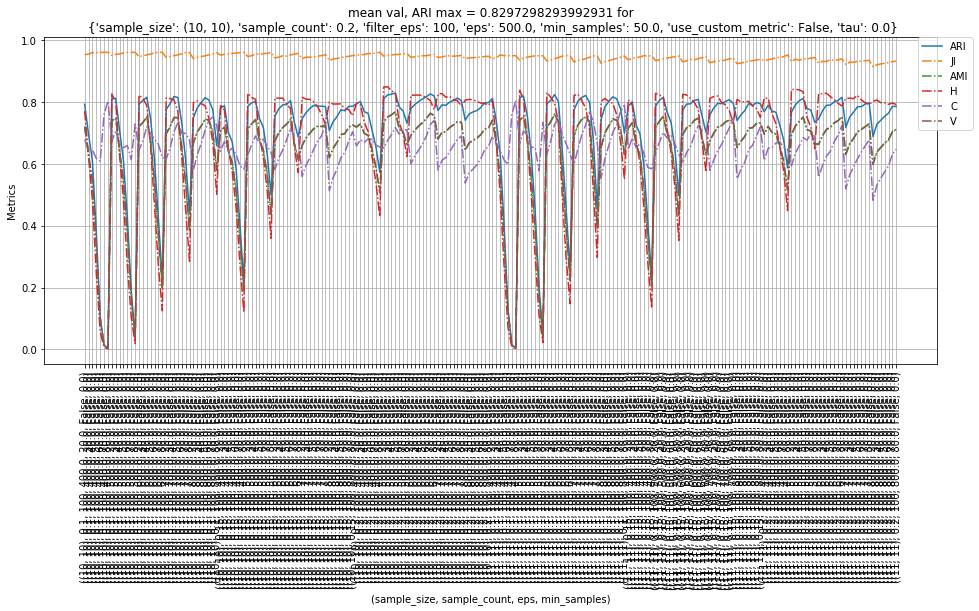

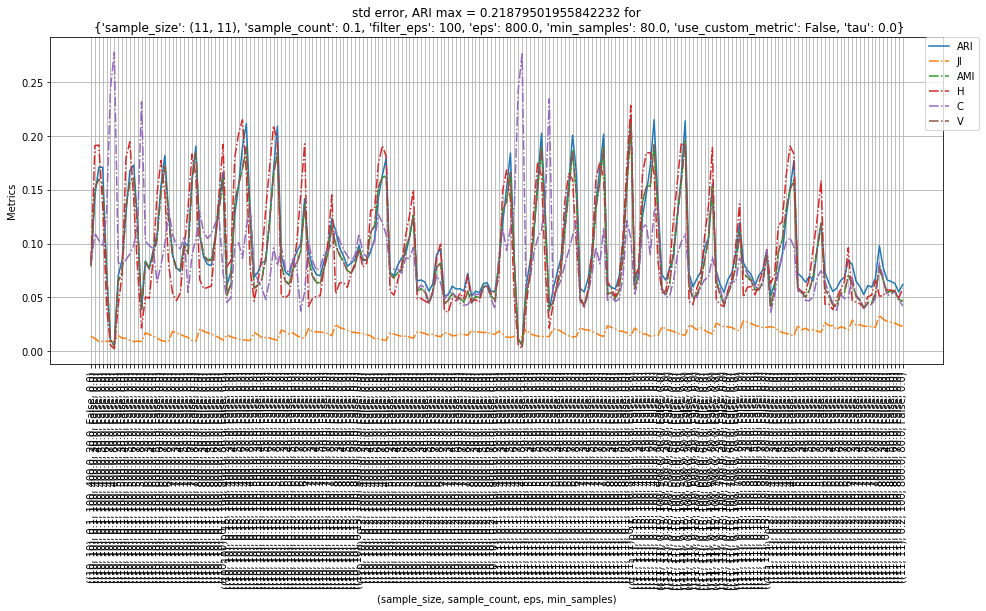

In [14]:
for i in range(3):
    metrics_i = [m[i] for m in metrics]
    plot_graphics(metrics_i, f'sample {i}')
metrics_mean = [m['mean'] for m in metrics]
plot_graphics(metrics_mean, f'mean val')
metrics_std = [m['std'] for m in metrics]
plot_graphics(metrics_std, f'std error')

Оптимальное значение ARI=0.8297 для (10,10), 0.2, 100, 500, 50